In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator #What do these do?
from matplotlib import cm
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Plot styling
#os.environ["PATH"] += os.pathsep + '/usr/bin' # To set latex= True?

plt.style.use('plot_style.txt')

# Textwidth of LaTeX file. Can be determined via \the\textwidth
textwidth = 483.69687

# Textwidth for powerpoint presentation:
presentation = False
if presentation:
    textwidth = 600

# Decide wether we want to save all figures
save_to_file = True

# Colors
cmap = cm.get_cmap('magma')

# Ticks
loc15 = plticker.MultipleLocator(base=15.0)
loc30 = plticker.MultipleLocator(base=30.0)

In [4]:
def set_size(textwidth, fraction=1, subplots=(1, 1), scale_factor=1, rescale_height=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Based largely on Jack Walton's post on ploting figures with matplotlib and LaTeX:
    https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    
    Input:
        textwidth: float or string
                Document width in points, or string of predined document type
        fraction: float, optional
                Fraction of the width which you wish the figure to occupy
        subplots: array-like, optional
                The number of rows and columns of subplots.
        scale_factor: Facto to scale width and height with
        rescale_height: Factor to rescale height
    Returns:
        fig_dim: tuple
                Dimensions of figure in inches
    """
    if textwidth == 'paper':
        # Textwidth of LaTeX file. Can be determined by typing
        # \the\textwidth
        # in your latex file and then compiling.
        width_pt = 483.69687
    elif textwidth == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = textwidth

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (scale_factor*fig_width_in, rescale_height*scale_factor*fig_height_in)

# Config

Select model

In [5]:
readable_model_names = ["model_532", "model_450_630", "model_450_532_630"]
readable_model_name = readable_model_names[0]

### Path to test dataset and model

In [6]:
data_directory = os.path.dirname(os.path.dirname(os.getcwd())) + '/aerosol_data'
data_directory

'/data/user/degen_d/aerosol/aerosol_data'

In [7]:
#test_datafile = data_directory +'raw_data/test_scaling_woangles/logP11/test_dataset.hdf5'

# 1 WL
if readable_model_name==readable_model_names[0]:
    test_datafile = data_directory + '/ML_data_unidmoal_2021_03/pre_log_ts-0.2_wl-532_ta-5-85-96-176/test_dataset.hdf5'
    model_directory = '/data/project/general/aerosolretriev/aerosol_results_d/hs_report/1wl_64'
# 2 WL
if readable_model_name==readable_model_names[1]:
    test_datafile = data_directory + '/ML_data_unidmoal_2021_03/pre_log_ts-0.2_wl-450-630_ta-5-85-96-176/test_dataset.hdf5'
    model_directory = '/data/project/general/aerosolretriev/aerosol_results_d/hs_report/2wl_30'
# 3 WL
if readable_model_name==readable_model_names[2]:
    test_datafile = data_directory + '/ML_data_unidmoal_2021_03/pre_log_ts-0.2_ta-5-85-96-176/test_dataset.hdf5'
    model_directory = '/data/project/general/aerosolretriev/aerosol_results_d/hs_report/3wl_14'

In [8]:
# Find directory for predictions
pred_dir = model_directory + '/predictions'

# List available models and choose the best, i.e. 0
model_names = [element[:-5] for element in list(np.sort(os.listdir(pred_dir)))]
print('Available models:')
print(model_names)

Available models:
['invertible_model', 'model_1_invertible_model', 'model_2_invertible_model', 'model_3_invertible_model', 'model_4_invertible_model']


In [9]:
# choose model
# e.g. 
# model_name = model_names[1]
model_name = model_names[0]
model_name

'invertible_model'

In [10]:
readable_model_name

'model_532'

### Load / create directories

In [11]:
# Create directory for plots
#plot_dir = model_directory + '/plots/model'
plot_dir = '/data/project/general/aerosolretriev/aerosol_results_d/plots_semesterarbeit'
if model_name=='invertible_model':
    plot_dir += '/' + readable_model_name
else:
    plot_dir += '/' + readable_model_name + '/' + model_name
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_d/plots_semesterarbeit/model_532'

In [12]:
# Load directory for model
if model_name=='invertible_model':
    model_dir = model_directory +'/model'
else:
    model_dir = model_directory + '/' + model_name[:-17]

In [13]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_d/hs_report/1wl_64/model'

# Load the model and the data (dvar, qoi) for testing

In [14]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, 'invertible_model', model_kwargs=kwargs)

In [15]:
dvar_test = pd.read_hdf(test_datafile, key = 'dvar')
qoi_test = pd.read_hdf(test_datafile, key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)
print('dvar', dvar_test.columns)
print('qoi', qoi_test.columns)

dvar Index(['n_532nm', 'k_532nm', 'V_tot', 'R_median', 'GSD'], dtype='object')
qoi Index(['P11_0.532_5', 'P11_0.532_6', 'P11_0.532_7', 'P11_0.532_8',
       'P11_0.532_9', 'P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12',
       'P11_0.532_13', 'P11_0.532_14',
       ...
       'P12_0.532_166', 'P12_0.532_167', 'P12_0.532_168', 'P12_0.532_169',
       'P12_0.532_170', 'P12_0.532_171', 'P12_0.532_172', 'P12_0.532_173',
       'P12_0.532_174', 'P12_0.532_175'],
      dtype='object', length=320)


# Extract column names for later plotting

In [16]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns
qoi_test_plot = qoi_test.copy()

In [17]:
# Load columns as integers for ploting
column_names = list(qoi_test.loc[:, list(qoi_test.filter(regex="(?=.*" + qoi_test.columns[0][4:10] + ")" + '(?=.*P11)', axis=1))].columns)
column_names = [re.sub('P11_', '', c_name) for c_name in column_names]
column_names = [re.sub(column_names[0][:6], '', c_name) for c_name in column_names]
angles = np.array([int(i) for i in column_names])

# Find wavelenths occuring in dataset
wavelengths = [re.findall(r"[-+]?\d*\.\d+|\d+", element) for element in dvar_test.columns if re.findall(r"[-+]?\d*\.\d+|\d+", element)]
wavelengths = list([val for sublist in wavelengths for val in sublist])
wavelengths = list(set(wavelengths))
wavelengths = list(np.sort(wavelengths))
print("Available wavelengths in this dataset:", wavelengths)

# Define latex column names
dvar_columns = ['$n_{' + wl + '}$' for wl in wavelengths] + ['$k_{' + wl + '}$' for wl in wavelengths]
dvar_columns += ['$V_{tot}$', '$r_m$', '$\sigma$']
dvar_columns_to_latex = dict(zip(dvar_test.columns, dvar_columns))
dvar_columns_to_latex

Available wavelengths in this dataset: ['532']


{'n_532nm': '$n_{532}$',
 'k_532nm': '$k_{532}$',
 'V_tot': '$V_{tot}$',
 'R_median': '$r_m$',
 'GSD': '$\\sigma$'}

In [18]:
# Sort column names by wavelength and P11 / PPF
wl = ['450', '532', '630']
wl_P11_450, wl_P11_532, wl_P11_630 = [], [], []
wl_P12_450, wl_P12_532, wl_P12_630 = [], [], []
for key in qoi_columns:
    if 'P11' in key:
        if '450' in key:
            wl_P11_450.append(key)
        elif '532' in key:
            wl_P11_532.append(key)
        elif '630' in key:
            wl_P11_630.append(key)
    else:
        if '450' in key:
            wl_P12_450.append(key)
        elif '532' in key:
            wl_P12_532.append(key)
        elif '630' in key:
            wl_P12_630.append(key)

wl_list_P11 = [wl_P11_450, wl_P11_532, wl_P11_630]
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

# Flat list
wl_list_P11_flat = wl_P11_450 + wl_P11_532 + wl_P11_630
wl_list_P12_flat = wl_P12_450 + wl_P12_532 + wl_P12_630

# Load predictions from file

In [19]:
dvar_pred_iv = pd.read_hdf(pred_dir + '/' + model_name + ".hdf5", key='inv')
qoi_pred_fw = pd.read_hdf(pred_dir + '/' + model_name + ".hdf5", key='fw')

In [20]:
# Turn logarithm of P_11 back to normal for test and predicted data
if False:
    qoi_pred_fw.loc[:, wl_list_P11_flat] = np.exp(qoi_pred_fw.loc[:, wl_list_P11_flat])
    qoi_test.loc[:, wl_list_P11_flat] = np.exp(qoi_test.loc[:, wl_list_P11_flat])

# Calculate metrics

## R2
Use either $R^2 = 1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$ or $R^2_{adj} = 1- \frac{(1-R^2)(n-1)}{n-k-1}$

### Forward

In [21]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test.values, qoi_pred_fw.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
#r2_adj_fw = np.round(r2_adj_fw, decimals=3)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw_round = np.round(r2_adj_fw, decimals=3)
print('Forward model:\n')
print('R2_min = ', min(r2_adj_fw_round.min()),';  R2_max = ', 
      max(r2_adj_fw_round.max()), "; Mean = {:1.3f}".format(np.mean(r2_adj_fw_round, axis = 1)[0]))

Forward model:

R2_min =  0.998 ;  R2_max =  1.0 ; Mean = 0.999


In [22]:
r2_adj_fw_round.sort_values(by=r2_adj_fw_round.index[0], axis = 1,ascending=True)

P11_0.532_5  P12_0.532_173  P12_0.532_174  P11_0.532_109  P11_0.532_99  \
0        0.998          0.998          0.998          0.998         0.998   

   P12_0.532_175  P11_0.532_6  P11_0.532_7  P11_0.532_11  P11_0.532_163  ...  \
0          0.998        0.998        0.998         0.999          0.999  ...   

   P12_0.532_74  P12_0.532_65  P12_0.532_67  P12_0.532_68  P12_0.532_69  \
0           1.0           1.0           1.0           1.0           1.0   

   P12_0.532_70  P12_0.532_71  P12_0.532_72  P12_0.532_66  P12_0.532_63  
0           1.0           1.0           1.0           1.0           1.0  

[1 rows x 320 columns]

#### Seperate between P11 and P12 and Plot

In [23]:
r2_adj_fw_p11 = r2_adj_fw.loc[:, wl_list_P11_flat].to_numpy().reshape(-1)
r2_adj_fw_p12 = r2_adj_fw.loc[:, wl_list_P12_flat].to_numpy().reshape(-1)

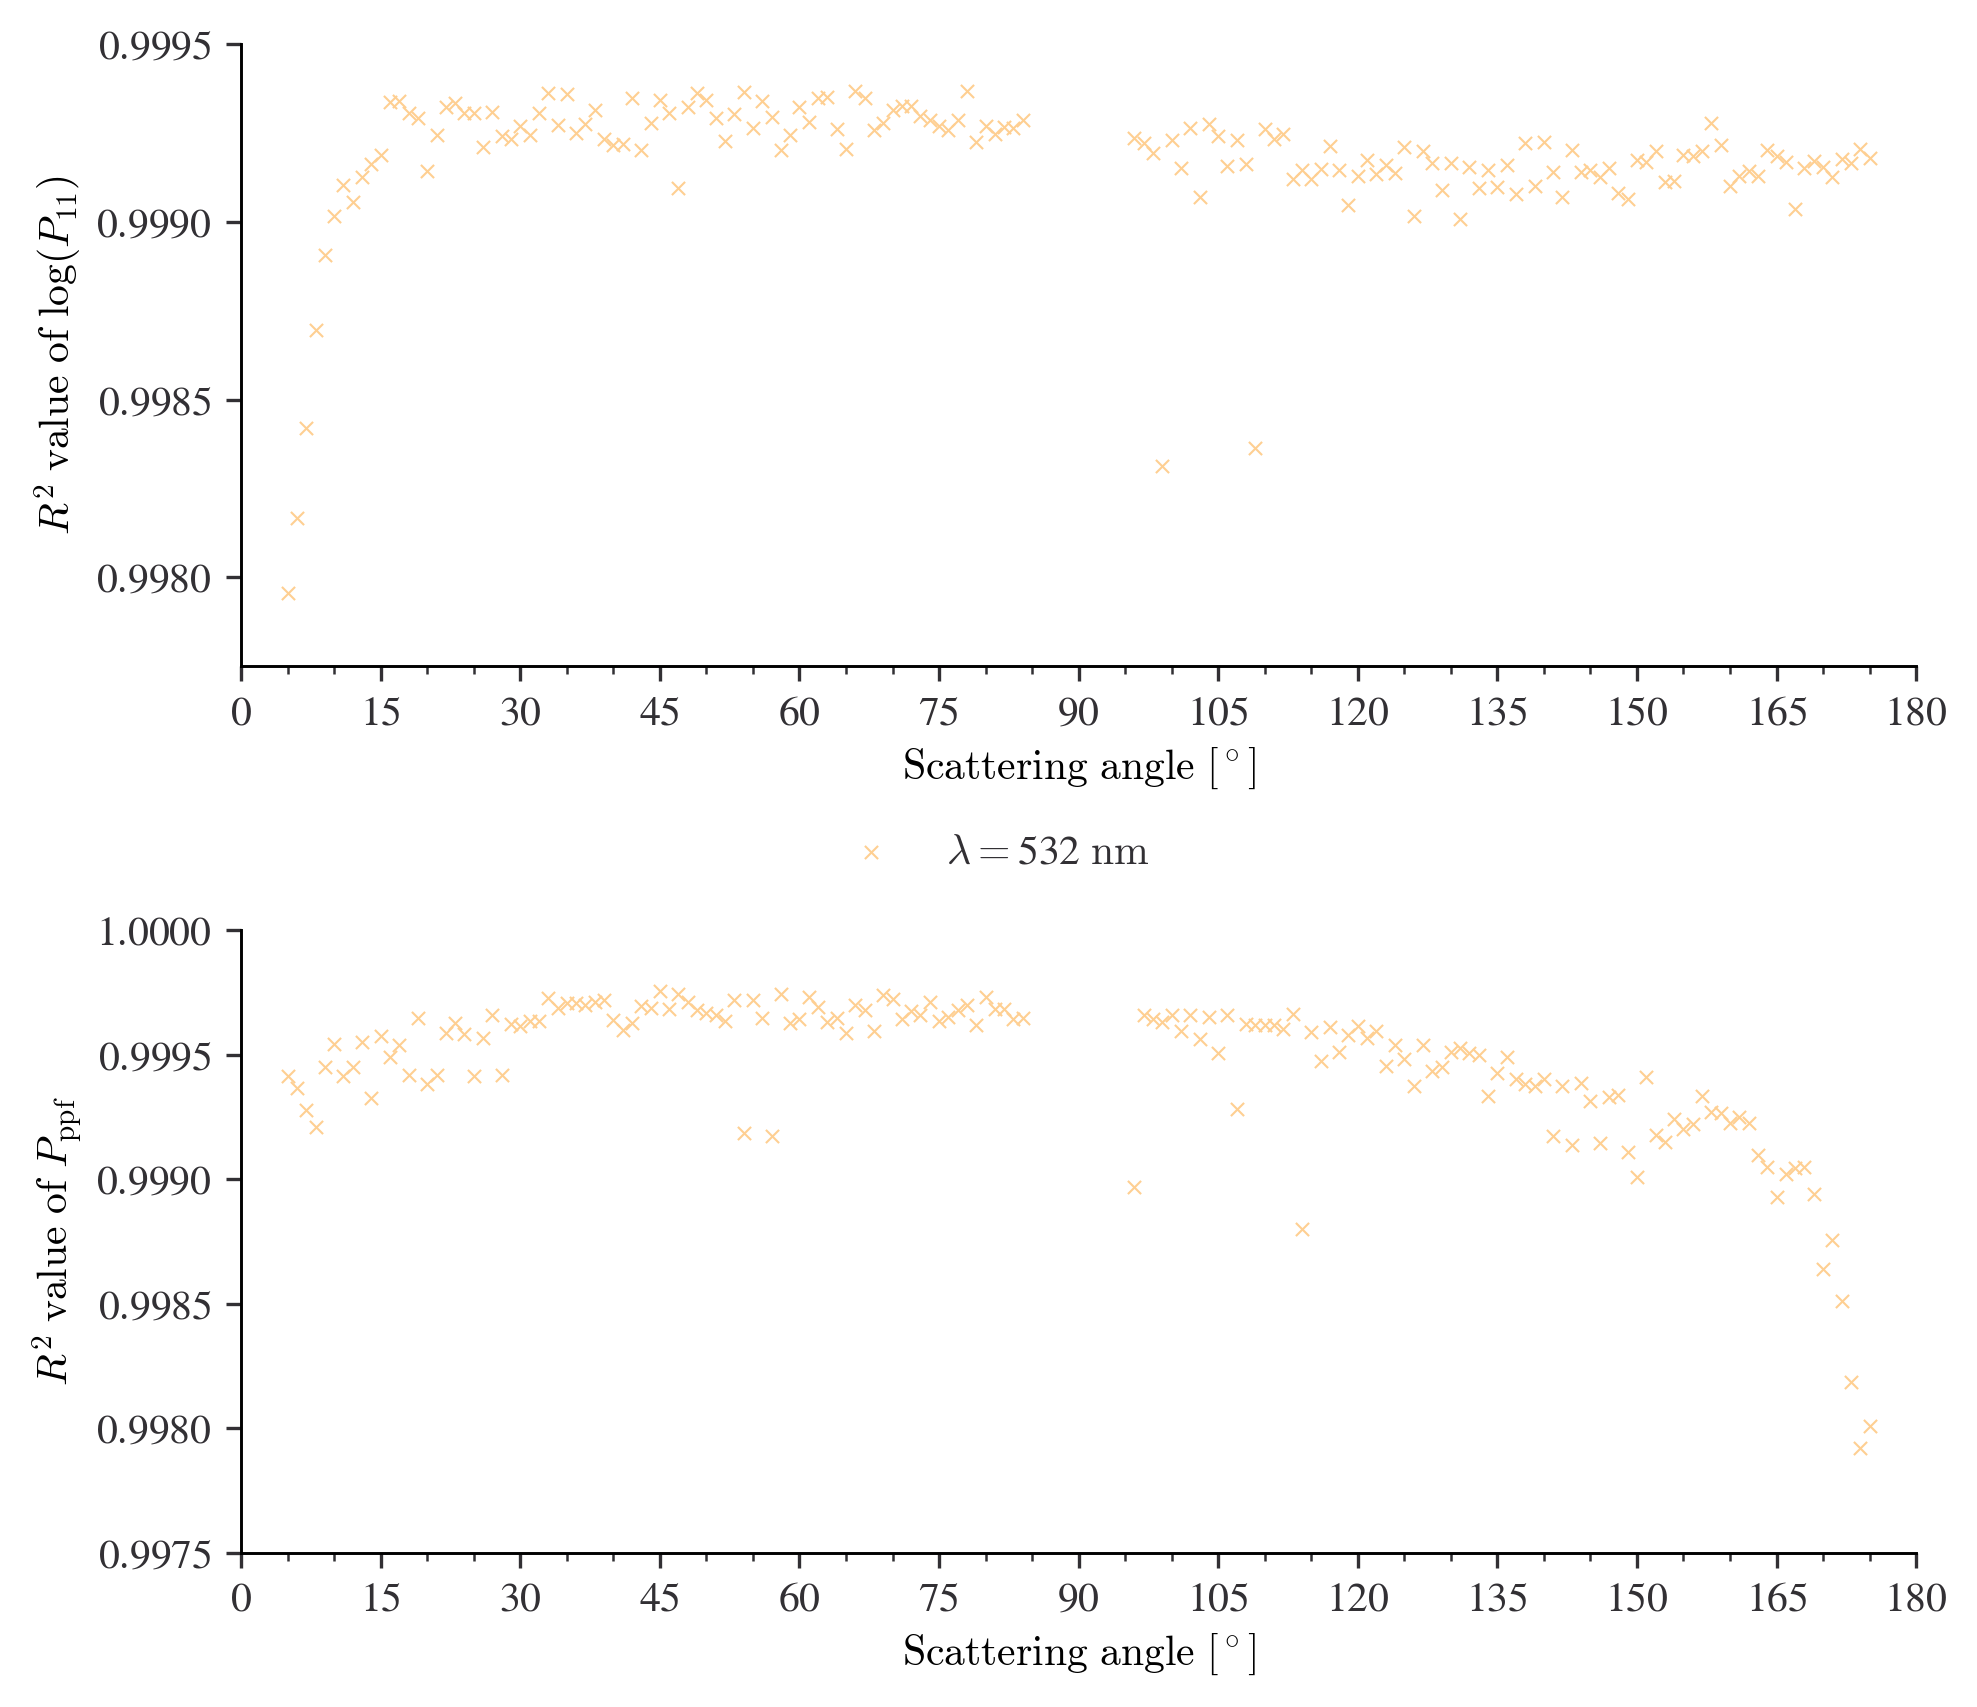

In [24]:
scat_style = {'s': 10, 'marker': 'x', 'alpha': 1, 'linewidths': 0.5}
color = [cmap(0.9), cmap(0.6), cmap(0.2)]

# Figure
nrows = 2
figsize = set_size(textwidth, subplots=(nrows, 1), rescale_height=0.7, scale_factor=1)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

j = 0
for i in range(3):
    if wl_list_P11[i]:  # wavelength non empty
        wl11 = wl_list_P11[i]
        wl12 = wl_list_P12[i]
        ax1 = axs[0]
        #ax1.set_title("$R^2$ $\operatorname{value\ of}$ $\log(P_{11})$")
        ax1.scatter(angles, r2_adj_fw.loc[:, wl_list_P11[i]],
                    label="$\lambda=$" + wavelengths[j] + " $\operatorname{nm}$", 
                    color=color[j], **scat_style)

        ax1.set_xlim(0, 180)
        ax1.set_xlabel("$\operatorname{Scattering\ angle}\ [^\circ]$")
        #ax1.locator_params(axis = 'x', tight=True, nbins=40)
        ax1.set_ylabel("$R^2$ $\operatorname{value\ of\ } \log(P_{11})$")
        ax1.xaxis.set_major_locator(loc15)
        ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
        #ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        ax1.tick_params(axis='x', which='minor', length=2)
        ax1.tick_params(axis='y', which='minor', length=2)        

        ax2 = axs[1]
        #ax2.set_title("$R^2$ $\operatorname{value\ of}$ $P_{\operatorname{ppf}}$")
        ax2.scatter(angles, r2_adj_fw.loc[:, wl_list_P12[i]], 
                    color=color[j], **scat_style)
        
        ax2.set_xlim(0, 180)        
        ax2.set_xlabel("$\operatorname{Scattering\ angle}\ [^\circ]$")
        #ax2.locator_params(axis = 'x', tight=True, nbins=40)
        #ax2.set_ylabel("$R^2$")
        ax2.set_ylabel("$R^2$ $\operatorname{value\ of\ } P_{\operatorname{ppf}}$")
        # ticks        
        ax2.xaxis.set_major_locator(loc15)
        ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
        #ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        ax2.tick_params(axis='x', which='minor', length=2)
        ax2.tick_params(axis='y', which='minor', length=2)
        j += 1

        
fig.legend(bbox_to_anchor=[0.5, 0.5], loc='center',  ncol=3, frameon=False)
fig.tight_layout(h_pad=3)
if save_to_file:
    plt.savefig(f'{plot_dir}/r2_adj_fw' + '.pdf', dpi=1000)
plt.show()

### Inverse

In [25]:
metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
#metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test.values, dvar_pred_iv.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.95 ;  R2_max =  1.0


$n_{532}$  $k_{532}$  $V_{tot}$  $r_m$  $\sigma$
0        1.0        1.0        1.0    1.0      0.95

In [26]:
np.mean(r2_adj_iv, axis = 1)

0    0.99
dtype: float64

In [27]:
# Latex Tabuar
if save_to_file:
    with open(f'{plot_dir}/tables.tex', 'w') as tf:
         tf.write(r2_adj_iv.to_latex(caption="$R_{adj}^2$", position='H', header=True,
                                     index=False, float_format="%.2f", escape=False))
else:
    print(r2_adj_iv.to_latex(caption="$R_{adj}^2$", position='H', header=True, 
                             index=False, float_format="%.2f", escape=False))

# Relative and absolute error

Absolute error: $\Delta_{abs} = |y_{true}-y_{pred}|$
Relative error: $\Delta_{rel} = \frac{\Delta_{abs}}{y_{true}} = \frac{y_{true}-y_{pred}}{y_{true}}$

The relative error is badly conditioned if $y_{true}$ is very small, which it is in our case for $P_{\operatorname{ppf}}$


## Forward

In [28]:
abs_error_fw = np.abs( qoi_test - qoi_pred_fw)

In [29]:
rel_error_fw = abs_error_fw / (qoi_test) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

### Quantile errors

In [30]:
# dictionary for quantiles of interest
quantiles = {
    0.5 : '$50 \%$',
    0.75: '$75 \%$',
    0.9 : '$90 \%$',
    0.95: '$95 \%$',
    0.99: '$99 \%$',
}
# number of decimals
dec = 3

In [31]:
# absolute error
abs_error_table_fw =  np.round(abs_error_fw.quantile([*quantiles]).rename(index=quantiles), decimals=dec)
#abs_error_table_fw

In [32]:
# relative error
rel_error_table_fw = np.round(rel_error_fw.quantile([*quantiles]).rename(index=quantiles), decimals=dec)
#rel_error_table_fw

#### Seperate P11, P12

In [33]:
# Seperate absolute errors
abs_error_table_fw_P11 = abs_error_table_fw[wl_list_P11_flat]
abs_error_table_fw_P12 = abs_error_table_fw[wl_list_P12_flat]

# Seperate relative errors
rel_error_table_fw_P11 = rel_error_table_fw[wl_list_P11_flat]
rel_error_table_fw_P12 = rel_error_table_fw[wl_list_P12_flat]

#### Maximal quantile error table

In [34]:
# Most comprehensive table
quantile_errors_table_fw = pd.concat([rel_error_table_fw_P11.max(axis = 1), 
                                      abs_error_table_fw_P12.max(axis = 1)], 
                                     axis=1).set_axis(['$\Delta_{rel} \log(P_{11})$',
                                                       '$\Delta_{abs} P_{\operatorname{ppf}}$'],
                                                      axis=1)
# Save to file
if save_to_file:
    with open(f'{plot_dir}/tables.tex', 'a') as tf:
         tf.write(quantile_errors_table_fw.to_latex(
                    caption="Max. rel. error in \% of $P_{11}$ and max. abs. error of $P_{\operatorname{ppf}}$", 
                    position='H', float_format="%.3f", escape=False))
else:
    print(quantile_errors_table_fw.to_latex(
        caption="Max. rel. error in \% of $P_{11}$ and max. abs. error of $P_{\operatorname{ppf}}$", 
        position='H', float_format="%.3f", escape=False))

print('max. rel. error in % of P11 and max. abs. error of P11/P12')
quantile_errors_table_fw

max. rel. error in % of P11 and max. abs. error of P11/P12


$\Delta_{rel} \log(P_{11})$  $\Delta_{abs} P_{\operatorname{ppf}}$
$50 \%$                        0.145                                  0.005
$75 \%$                        0.253                                  0.009
$90 \%$                        0.380                                  0.013
$95 \%$                        0.489                                  0.016
$99 \%$                        1.108                                  0.035

#### Quantile error Plot

In [35]:
# Heat PLot
nrows = len(wavelengths)
figsize = set_size(textwidth, scale_factor=1, subplots=(nrows, 2))

if len(wavelengths)==1:
    figsize = set_size(textwidth, scale_factor=1, subplots=(nrows, 2), rescale_height=1.1)

if presentation: 
    figsize = set_size(textwidth, scale_factor=1, subplots=(2, nrows))
    fig, axes = plt.subplots(nrows=2, ncols=nrows, figsize=figsize)
    axes = axes.T
else:
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)

# Adjust spacing for plot title
fig.subplots_adjust(top=0.9)
#fig.suptitle('$\operatorname{Relative\ error\ of}$ $\log(P_{11})$ $\operatorname{and\ absolute\ error\ of}$ $P_{\operatorname{ppf}}$') #, y=0.98)

empty = pd.DataFrame(np.zeros((5, 180)), index=[*quantiles.values()]) - 0.0001

for i, wl in enumerate(wavelengths):
    # To account for empty angles

    if len(wavelengths)==1:
        ax_row = axes
    else:
        ax_row = axes[i]
    
    # Plot relative error
    ax = ax_row[0]
    rel_error_table_fw_P11_wl = rel_error_table_fw_P11.loc[:, [el for el in rel_error_table_fw_P11.columns if str(wavelengths[i]) in el]]
    rel_error_table_fw_P11_wl = rel_error_table_fw_P11_wl.set_axis(angles, axis=1)
    
    sns.heatmap(empty.add(rel_error_table_fw_P11_wl, fill_value=0),
            cmap='Reds',
            linewidths=0.00, #0.005
            vmin=0.,
            cbar=True,
            cbar_kws={'label': r'$\left| \frac{y - \hat{y}}{y} \right|\ [\%]$'},
            vmax=np.max(rel_error_table_fw_P11.max()),
            xticklabels=30,
            ax=ax
            )
    # Major ticks
    ax.tick_params(rotation=0, grid_color='b', grid_alpha=0.5, length=1.5, width=1)
    # Minor ticks
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
    ax.tick_params(axis='x', which='minor', length=0.7)
    ax.tick_params(axis='y', which='minor', length=0)    
    ax.tick_params(axis='y', length=0)
    
    # Title
    ax.set_title('$\Delta_{rel} \log(P_{11})$ for ' + f'$\lambda = {wl}$')
    ax.set_xlabel('$\operatorname{Scattering\ angle}$ $[^\circ]$')
    ax.set_ylabel('$\operatorname{Quantile}$')

    # Plot absolute error
    ax = ax_row[1]    
    abs_error_table_fw_P12_wl = abs_error_table_fw_P12.loc[:, [el for el in abs_error_table_fw_P12.columns if str(wavelengths[i]) in el]]
    abs_error_table_fw_P12_wl = abs_error_table_fw_P12_wl.set_axis(angles, axis=1)
    sns.heatmap(empty.add(abs_error_table_fw_P12_wl, fill_value=0),
            cmap='Reds',
            linewidths=0, #0.001,
            vmin=0.,
            cbar=True,
            cbar_kws={'label': r'$\left| y - \hat{y} \right| $',
                      #'use_gridspec': False, 'location': "right"
                     },
            vmax=np.max(abs_error_table_fw_P12.max()),
            xticklabels=30,
            ax=ax
            )
    # Major ticks
    ax.tick_params(rotation=0, grid_color='b', grid_alpha=0.5, length=1.5, width=1)
    # Minor ticks
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
    ax.tick_params(axis='x', which='minor', length=0.7)
    ax.tick_params(axis='y', which='minor', length=0)    
    ax.tick_params(axis='y', length=0)
    
    ax.set_title('$\Delta_{abs} P_{\operatorname{ppf}}$ for ' + f'$\lambda = {wl}$')   
    ax.set_xlabel('$\operatorname{Scattering\ angle}$ $[^\circ]$')
    ax.set_ylabel('$\operatorname{Quantile}$')     

fig.tight_layout()

if save_to_file:
    if presentation:
        fig.savefig(f'{plot_dir}/pres_forward_rel_error_percentiles.pdf')
    else:
        fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.pdf')
plt.show()

## Inverse

In [36]:
abs_error_iv = np.abs(dvar_test-dvar_pred_iv).set_axis(dvar_columns, axis=1)
#abs_error_iv

In [37]:
# Absolute error
abs_error_table_iv = np.round(abs_error_iv.quantile([*quantiles]).rename(index=quantiles), decimals=4)
#abs_error_table_iv = abs_error_table_iv.set_axis(dvar_columns, axis=1)
abs_error_table_iv.style.set_caption("Absolute error")

In [38]:
rel_error_iv = ((abs_error_iv / (dvar_test.set_axis(dvar_columns, axis=1)) * 100.).abs())

In [39]:
# Relative error
rel_error_table_iv = np.round(rel_error_iv.quantile([*quantiles]).rename(index=quantiles), decimals=4)
#rel_error_table_iv.style.set_caption("Relative error")

My own percentage error
for $x \in X$, $MOPE_X(x) = \frac{\Delta_{abs} x}{max_{y \in X}-min_{y \in X}} $.

The idea is to compare the absolute error with the length of the range of the respective variable.

In [40]:
# My own percentage error
MOPE = abs_error_table_iv/((dvar_test.max() - dvar_test.min()).set_axis(dvar_columns, axis=0))*100
MOPE.style.set_caption("My own percentage error")

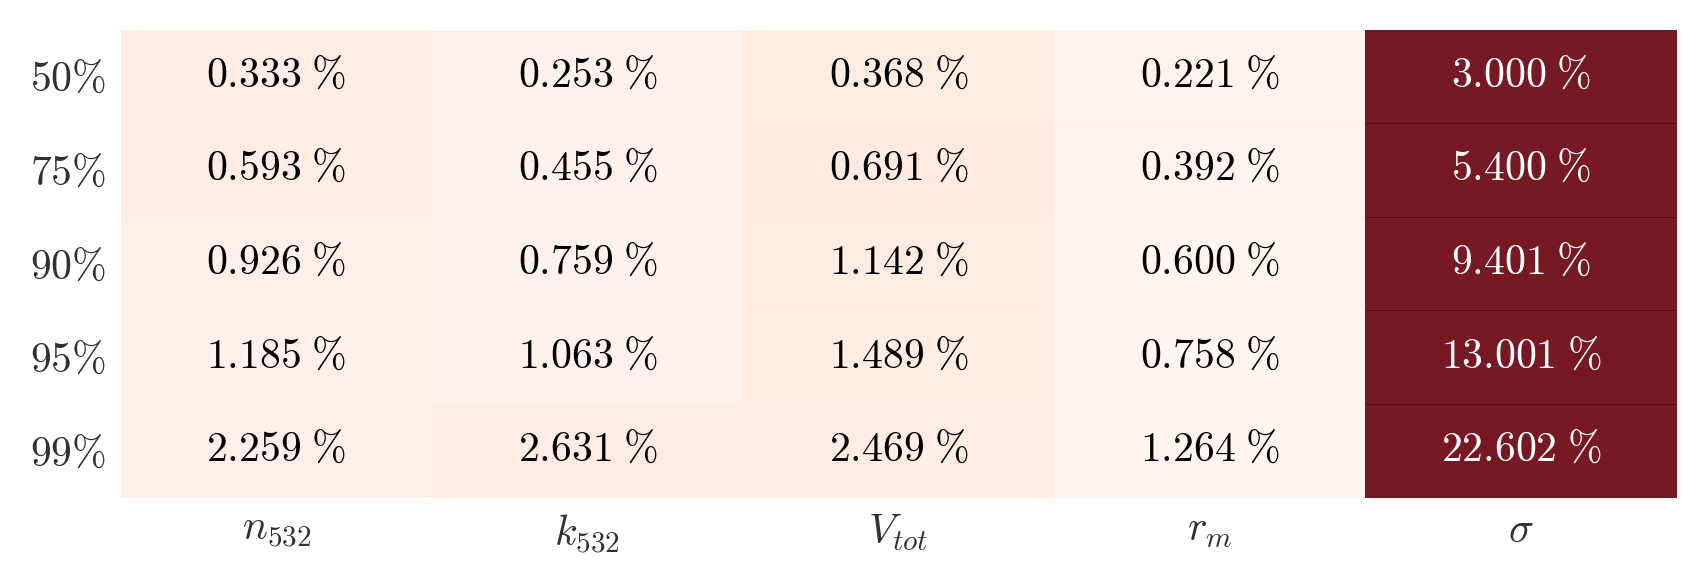

In [41]:
def heatmap_from_pandas(rev_df, colorbar=False, textkw=dict(), suffix='', threshold=None, title="Error", fraction=1):
    # Reverse order, to match tables
    df = rev_df.iloc[::-1]
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)
    textcolors=("black", "white")

    df_max = df.div(df.max(axis=1), axis=0)
    
    figsize = set_size(textwidth, fraction=fraction, subplots=(1, 1), rescale_height=0.5, scale_factor=1)
    fig = plt.figure(figsize=figsize)
    
    heatmap = plt.pcolor(df_max, cmap='Reds', alpha=.9)
    
    if threshold == None:
        threshold = heatmap.norm(df.max(axis=0))
    else:
        #threshold = [threshold for element in range(len(df_max.columns))]
        threshold = threshold*heatmap.norm(df.max(axis=1))
    
    # Write values
    plt.title(title)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            kw.update(color=textcolors[int(heatmap.norm(df.iloc[y, x]) > threshold[y])])            
            plt.text(x + 0.5, y + 0.5, '$' '%.3f' % df.iloc[y, x] + '$' + suffix,
                     alpha=1,
                     **kw
                     )
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.tick_params(length=0)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    if colorbar==True:
        plt.colorbar(heatmap)
    if save_to_file:
        plt.savefig(f'{plot_dir}/own' + '.pdf', dpi=1000)
    plt.show()

#heatmap_from_pandas(rel_error_table_iv, colorbar=False, threshold=0.8, title="Relative Error")
#heatmap_from_pandas(abs_error_table_iv, colorbar=False, threshold=0.8, title="Absolute Error")
# My own percentage error
heatmap_from_pandas(MOPE, colorbar=False, threshold=0.8, suffix=' $\%$', 
                    title="", # $\Delta_{abs} \ \operatorname{normalized\  by\  feature\  range}$"
                    fraction=1)

In [42]:
# To latex table
if save_to_file:
    with open(f'{plot_dir}/tables.tex', 'a') as tf:
         tf.write(abs_error_table_iv.to_latex(caption="Absolute error", 
                                              position='H', 
                                              float_format="%.3f", 
                                              escape=False))
else: 
    print(abs_error_table_iv.to_latex(caption="Absolute error", 
                                      position='H', float_format="%.3f", 
                                      escape=False))

# Correlation between test data and predicted data

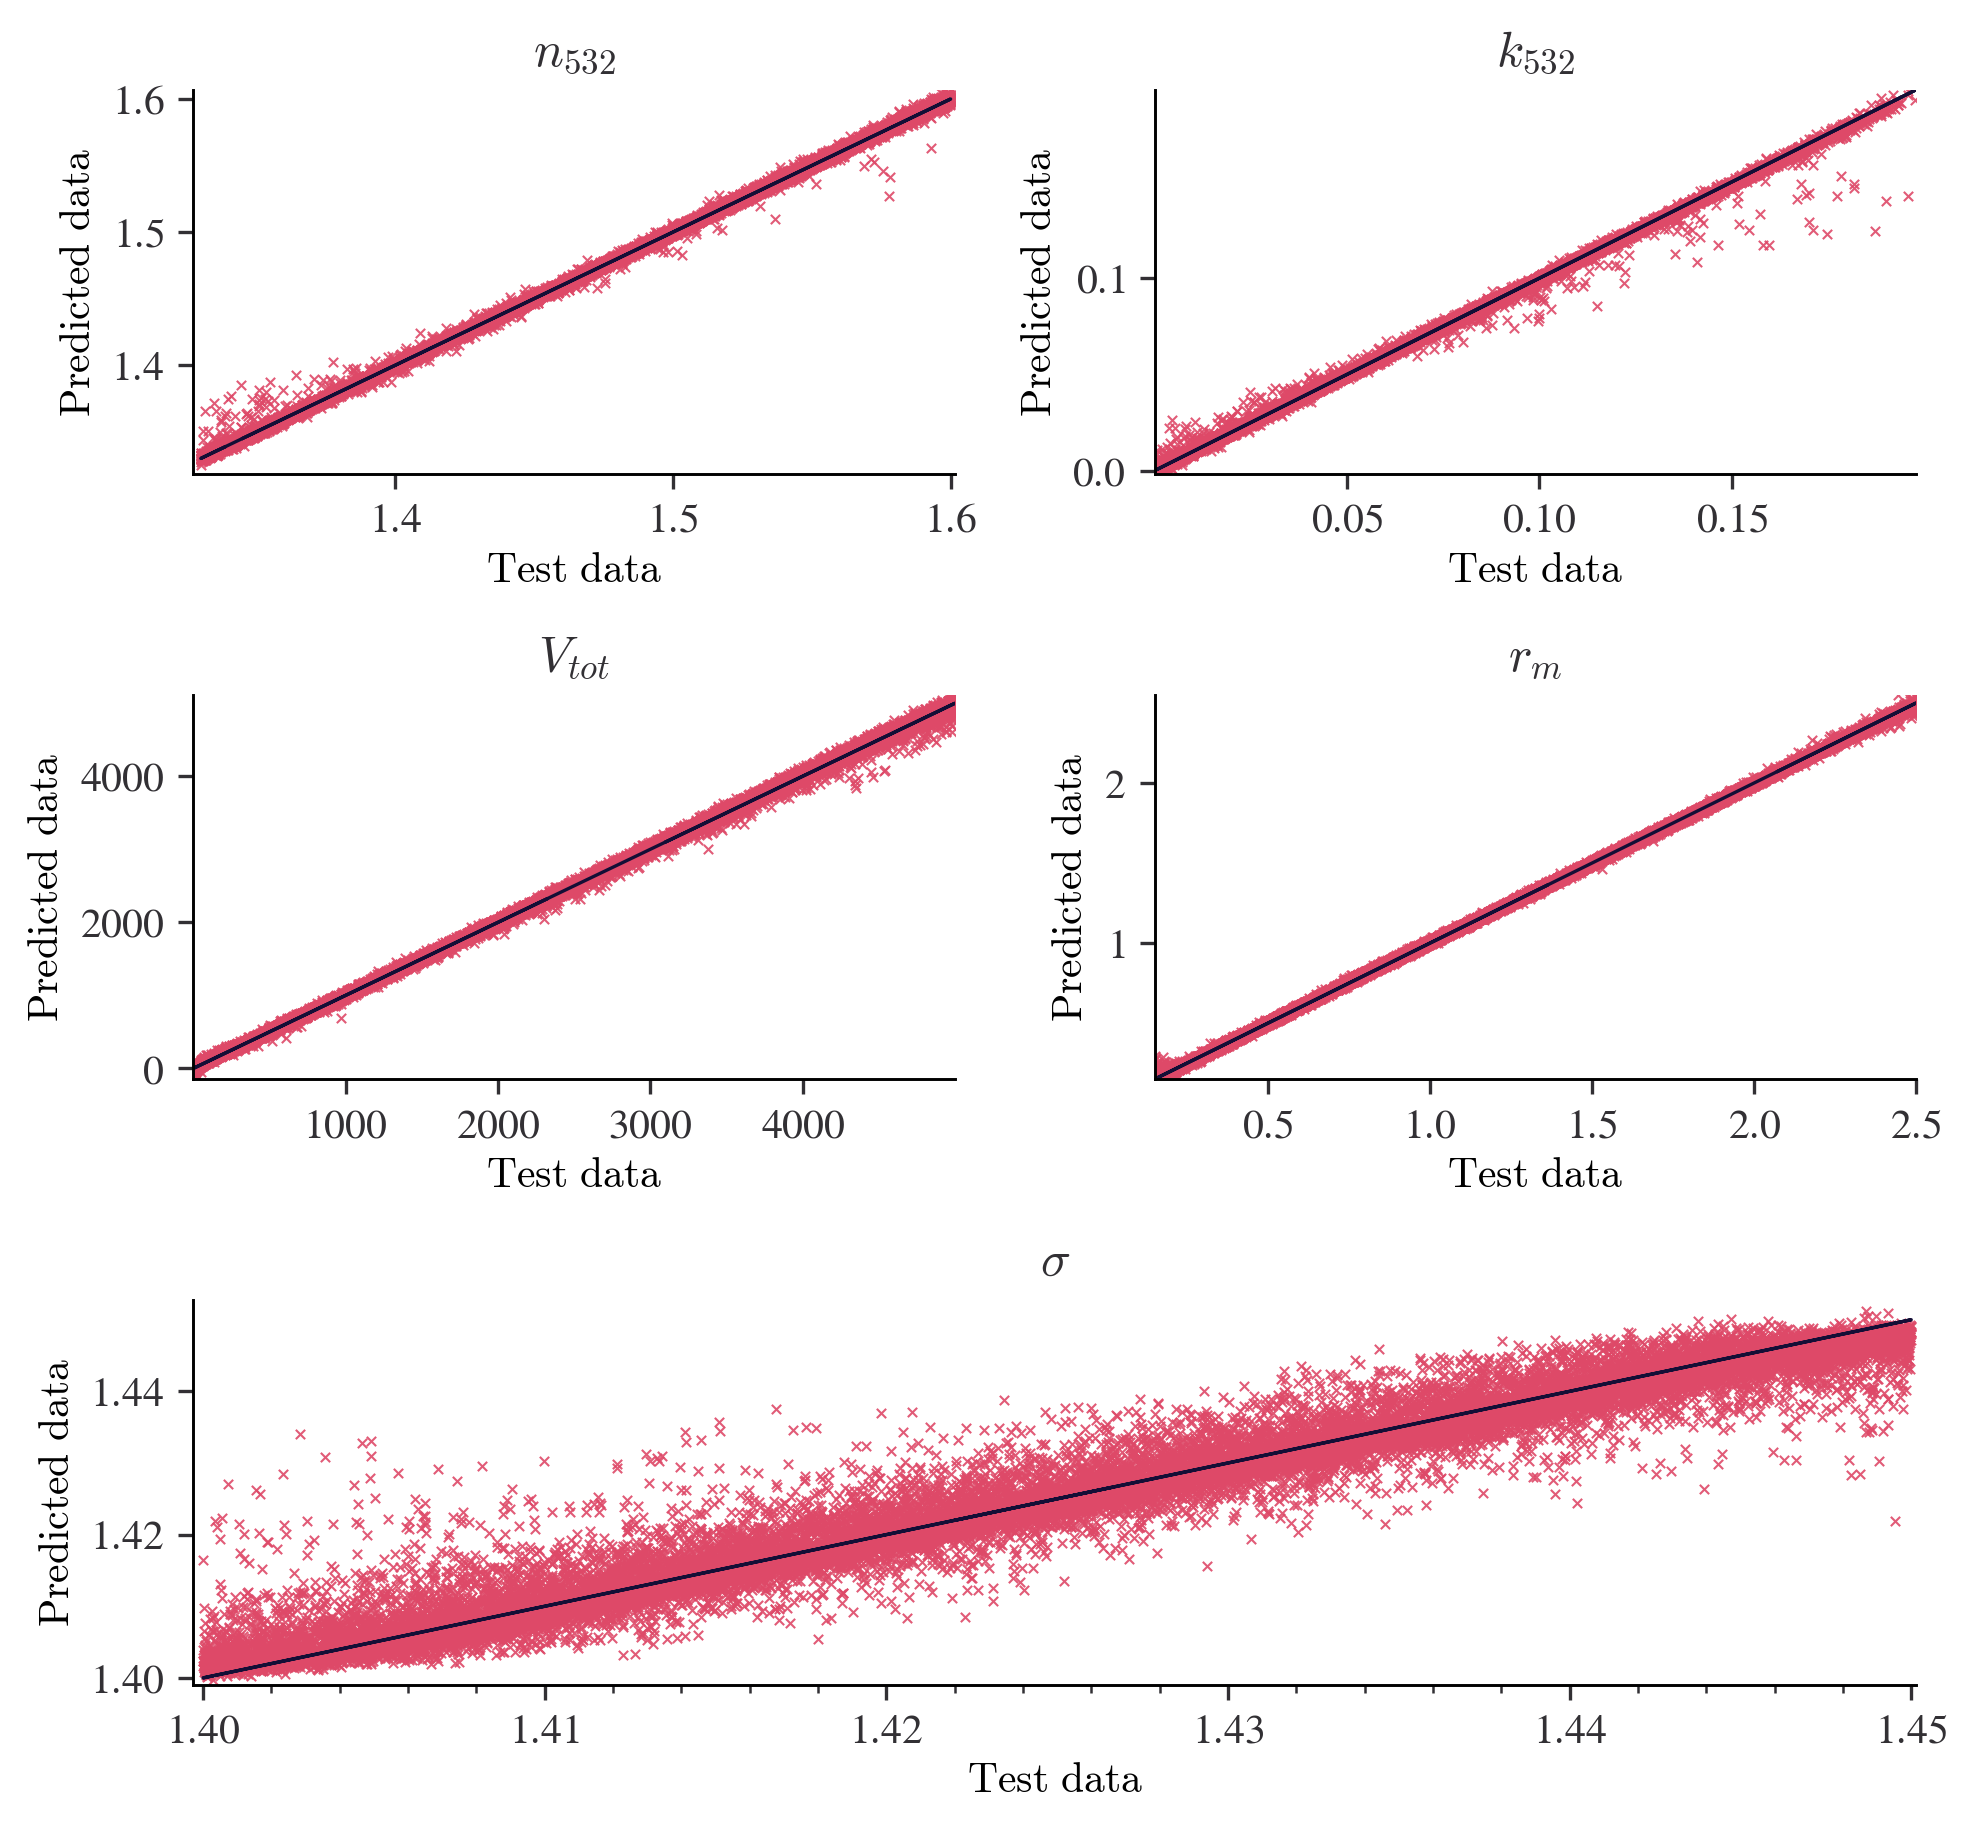

In [43]:
color = [cmap(0.6), cmap(0.1)]
scat_style = {'s': 5, 'marker': 'x', 'alpha': 0.9, 'linewidths': 0.5}

ncols = 2

# Special formating for different wavelength configurations
if len(wavelengths)==2:
    nrows = int(np.round(len(dvar_test.columns)/2, 0))
else:
    nrows = int(np.round(len(dvar_test.columns)/2, 0)+1)    
    
figsize = set_size(textwidth, scale_factor=1, subplots=(nrows, ncols))
if len(wavelengths)==3:
    figsize = set_size(textwidth, scale_factor=1, subplots=(nrows, ncols), rescale_height=0.75)
    
if presentation:
    nrows = 3
    figsize = set_size(textwidth, scale_factor=1, subplots=(ncols+1, nrows))
    fig, axs = plt.subplots(nrows=ncols+1, ncols=nrows, figsize=figsize)
else:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    #fig.suptitle('$\operatorname{Quantitative\ comparison\ of\ test\ data\ with\ predicted\ data}$')

gs = axs[-1, 0].get_gridspec()
# remove the underlying axes of last row
for ax in axs[-1, :]:
    ax.remove()
last_ax = fig.add_subplot(gs[-1, :])

if presentation: 
    axs = axs.T

# Wavelength dependent
# Of the form [['n_450nm', 'k_450nm'], ['n_630nm', 'k_630nm']]
wavlength_dependent = [[element for element in dvar_test.columns if wl in element] for wl in wavelengths]
for index, element in enumerate(wavlength_dependent):
    for i in range(2):
        ax = axs[index][i]
        key = element[i]
        ax.scatter(dvar_test[key], dvar_pred_iv[key], color=color[0], rasterized=True, **scat_style)
        ax.plot(dvar_test[key],dvar_test[key], color=color[1])
        ax.set_title(dvar_columns_to_latex[key])
        ax.set_xlabel('$\operatorname{Test\ data}$')
        ax.set_ylabel('$\operatorname{Predicted\ data}$')
        # Minor ticks
        ax.set_xlim(np.min(dvar_test[key]), np.max(dvar_test[key]))
        #ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        #ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))        
        #ax.tick_params(axis='x', which='minor', length=2)
        #ax.tick_params(axis='y', which='minor', length=2)   
        ax.set_xlim(left=np.min(dvar_test[key])*0.998,
                    right=np.max(dvar_test[key])*1.001)
        ax.set_ylim(bottom=min(np.min(dvar_test[key]), np.min(dvar_pred_iv[key]))*0.995,
                    top=max(np.max(dvar_test[key]), np.max(dvar_pred_iv[key]))*1.001)        


# Wavelength independent
for index, element in enumerate(['V_tot', 'R_median']):
        ax = axs[-2][index]
        key = element
        ax.scatter(dvar_test[key], dvar_pred_iv[key], color=color[0], rasterized=True, **scat_style)
        ax.plot(dvar_test[key], dvar_test[key], color=color[1])
        ax.set_title(dvar_columns_to_latex[key])
        ax.set_xlabel('$\operatorname{Test\ data}$')
        ax.set_ylabel('$\operatorname{Predicted\ data}$')
        # Minor ticks
        #ax.set_xlim(np.min(dvar_test[key]), np.max(dvar_test[key]))
        #ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        #ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))        
        #ax.tick_params(axis='x', which='minor', length=2)
        #ax.tick_params(axis='y', which='minor', length=2)    
        ax.set_xlim(left=np.min(dvar_test[key])*0.9998,
                    right=np.max(dvar_test[key])*1.0001)
        ax.set_ylim(bottom=min(np.min(dvar_test[key]), np.min(dvar_pred_iv[key]))*1,
                    top=max(np.max(dvar_test[key]), np.max(dvar_pred_iv[key]))*1.001)

# Make last axis twice as wide
ax = last_ax
key = 'GSD'
ax.scatter(dvar_test[key],dvar_pred_iv[key], color=color[0], rasterized=True, **scat_style)
ax.plot(dvar_test[key],dvar_test[key], color=color[1])
ax.set_title(dvar_columns_to_latex[key])
ax.set_xlabel('$\operatorname{Test\ data}$')
ax.set_ylabel('$\operatorname{Predicted\ data}$')
# Minor ticks
ax.set_xlim(np.min(dvar_test[key]), np.max(dvar_test[key]))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))        
ax.tick_params(axis='x', which='minor', length=2)
#ax.tick_params(axis='y', which='minor', length=2)  
ax.set_xlim(left=np.min(dvar_test[key])*0.9998,
            right=np.max(dvar_test[key])*1.0001)
ax.set_ylim(bottom=min(np.min(dvar_test[key]), np.min(dvar_pred_iv[key]))*0.9995,
            top=max(np.max(dvar_test[key]), np.max(dvar_pred_iv[key]))*1.001)

fig.tight_layout()


if save_to_file:
    if presentation:
        fig.savefig(f'{plot_dir}/pres_quantitative_comparison_rasterized.pdf', dpi=500)
    else:
        fig.savefig(f'{plot_dir}/Quantitative_comparison_rasterized.pdf', dpi=500)
plt.show()

# Qualitative aerosol plots

In [44]:
# Choose indeces of curves to draw for illustrative purposes
number_of_illustrative_curves = 5
presentation_plot_index = [i*(qoi_test.shape[0]//number_of_illustrative_curves) for i in range(number_of_illustrative_curves)]
presentation_plot_index = [1000, 4000, 8000, 13000, 15000] #[0, 2100, 5000, 1000, 16000]

Reasoning for error:

$x \pm \Delta_{rel} x = x \pm x*0.01 = x(1 \pm 0.01) \implies \log(x(1 \pm 0.01)) = \log(x) + \log(1 \pm 0.01)$

$(\log(1 + 0.01), \log(1 - 0.01)) = (0.009950, -0.010050)$

In [45]:
color = [cmap(0.8), cmap(0.3)]
scat_style = {'s': 16, 'marker': 'x', 'alpha': 0.9, 'linewidths': 0.4}
scat_style_pred = {'s': 5, 'marker': '.', 'alpha': 0.7, 'linewidths': 0.4}

errbar_style = {'markersize': 3, 'markeredgewidth': 0.3, 
                'ecolor': color[1], 'color': color[1], 'mec': color[1], 'mfc': color[1], 
                'label': 'Predictions', 'fmt': '.', 
                'capsize': 0, 'elinewidth': 0.4, 'capthick': 0.0}

bbox_to_anchor = [0.5, -0.4]


if presentation: 
    nrows = len(wavelengths)
    figsize = set_size(textwidth, subplots=(2, nrows), rescale_height=1.4)
    fig, axs = plt.subplots(nrows=2, ncols=nrows, figsize=figsize)
    axs = axs.T
    bbox_to_anchor = [0.5, -0.4]
else:
    nrows = len(wavelengths)
    figsize = set_size(textwidth, subplots=(nrows, 1), rescale_height=0.7)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    #fig.suptitle('$\operatorname{Qualitative\ comparison\ of\ test\ data\ with\ predicted\ data}$')
    #fig.subplots_adjust(top=0.8)


scat_angles = int(np.mean([len(x) for x in wl_list_P11 if x]))
rel_err = 0.1
err = np.vstack([[np.log(1 + rel_err) for i in range(scat_angles)], [np.log(1 - rel_err) for i in range(scat_angles)]])

# P11
j = 0
for wl_item in wl_list_P11:
    # Plot if not empty
    if wl_item:
        if len(wavelengths)==1:
            ax = axs[0]
        else:
            ax = axs[j][0]
        for index in presentation_plot_index:
            ax.scatter(angles, np.exp(qoi_test[wl_item].iloc[index]), label='Test', color=color[0], **scat_style) 
            ax.scatter(angles, np.exp(qoi_pred_fw[wl_item].iloc[index]), color=color[1],
                       label='pred', **scat_style_pred)
            #ax.errorbar(angles, qoi_pred_fw[wl_item].iloc[index], 
            #            yerr=err, **errbar_style)
        ax.set_xlim(0, 180)
        ax.set_xlabel('$\operatorname{Scattering\ angle}$ $[^\circ]$')
        ax.set_ylabel('$P_{11}$')  # \ [\operatorname{m}^{-1}\operatorname{sr}^{-1}]$')

        # ticks
        ax.set_yscale('log')
        ax.xaxis.set_major_locator(loc30)
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
        ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
        ax.tick_params(axis='x', which='minor', length=2)
        #ax.tick_params(axis='y', which='minor', length=2)
        
        ax.set_title('$\lambda$ = ' + wavelengths[j])
        
        # Correct legend
        if j==0 and not presentation:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{11}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{11}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)
        # If all wavelengthes are plotted
        if len(wavelengths)==3 and j==1:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{11}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{11}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)
        if presentation and j==1:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{11}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{11}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)          
        
            # Go to next wavelength
        j += 1

# PPF
j = 0
for wl_item in wl_list_P12:
    # Plot if not empty
    if wl_item:
        if len(wavelengths)==1:
            ax = axs[1]
        else:
            ax = axs[j][1]
        for index in presentation_plot_index:
            ax.scatter(angles, qoi_test[wl_item].iloc[index], color=color[0], 
                       label='Test data', **scat_style)  #, 'b*'
            ax.scatter(angles, qoi_pred_fw[wl_item].iloc[index], color=color[1], 
                       label='pred', **scat_style_pred)  # ,'r.'
            #ax.errorbar(angles, qoi_pred_fw[wl_item].iloc[index], 
            #            yerr=0.01, **errbar_style)

        ax.set_xlim(0, 180)
        ax.set_xlabel('$\operatorname{Scattering\ angle}$ $[^\circ]$')
        ax.set_ylabel('$P_{\operatorname{ppf}}$')
        
        # ticks
        ax.xaxis.set_major_locator(loc30)
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        ax.tick_params(axis='x', which='minor', length=2)
        ax.tick_params(axis='y', which='minor', length=2)
        #ax.grid(color='0.0', alpha=0.01, which='minor', linestyle='-')
        #ax.xaxis.grid(color='0.0', alpha=0.05, linestyle='-')        
        #ax.yaxis.grid(color='0.0', alpha=0.05, linestyle='-')


        ax.set_title('$\lambda$ = ' + wavelengths[j])
        
        # Correct legend
        if j==0 and not presentation:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{ppf}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{ppf}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)
        # If all wavelengthes are plotted            
        if len(wavelengths)==3 and j==1:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{ppf}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{ppf}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)            
        # If presentation
        if presentation and j==1:
            handles_full = ax.get_legend_handles_labels()
            handles = [handles_full[0][0], handles_full[0][-1]]
            ax.legend(handles = handles, 
                      labels=['$P_{\operatorname{ppf}}\ \operatorname{test\ data}$', 
                              '$P_{\operatorname{ppf}}\ \operatorname{predicted\ data}$'],
                      bbox_to_anchor=bbox_to_anchor, loc='center',  ncol=2, frameon=False)          
        
        # Go to next wavelength
        j += 1
plt.grid

if len(wavelengths)==1:
    fig.tight_layout(w_pad=1)
    fig.subplots_adjust(bottom=0.2) 
if len(wavelengths)==2:
    fig.tight_layout(h_pad=0.4, w_pad=1)
if len(wavelengths)==3 and not presentation:
    fig.tight_layout(h_pad=0.4, w_pad=1)
    fig.subplots_adjust(bottom=0.2)
if presentation:
    fig.tight_layout(h_pad=0.125, w_pad=-1.4)
    fig.subplots_adjust(bottom=0.2) 
    
if save_to_file:
    if presentation:
        plt.savefig(f'{plot_dir}/pres_curve_fw' + '.pdf', dpi=1000, bbox_inches='tight')
    else:
        plt.savefig(f'{plot_dir}/curve_fw' + '.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [46]:
def lognormal_distr(r, rm, sigma, V):
    return V/(np.sqrt(2*np.pi)*sigma*r)*np.exp(-(np.log(r) - np.log(rm))**2/(2*sigma**2))

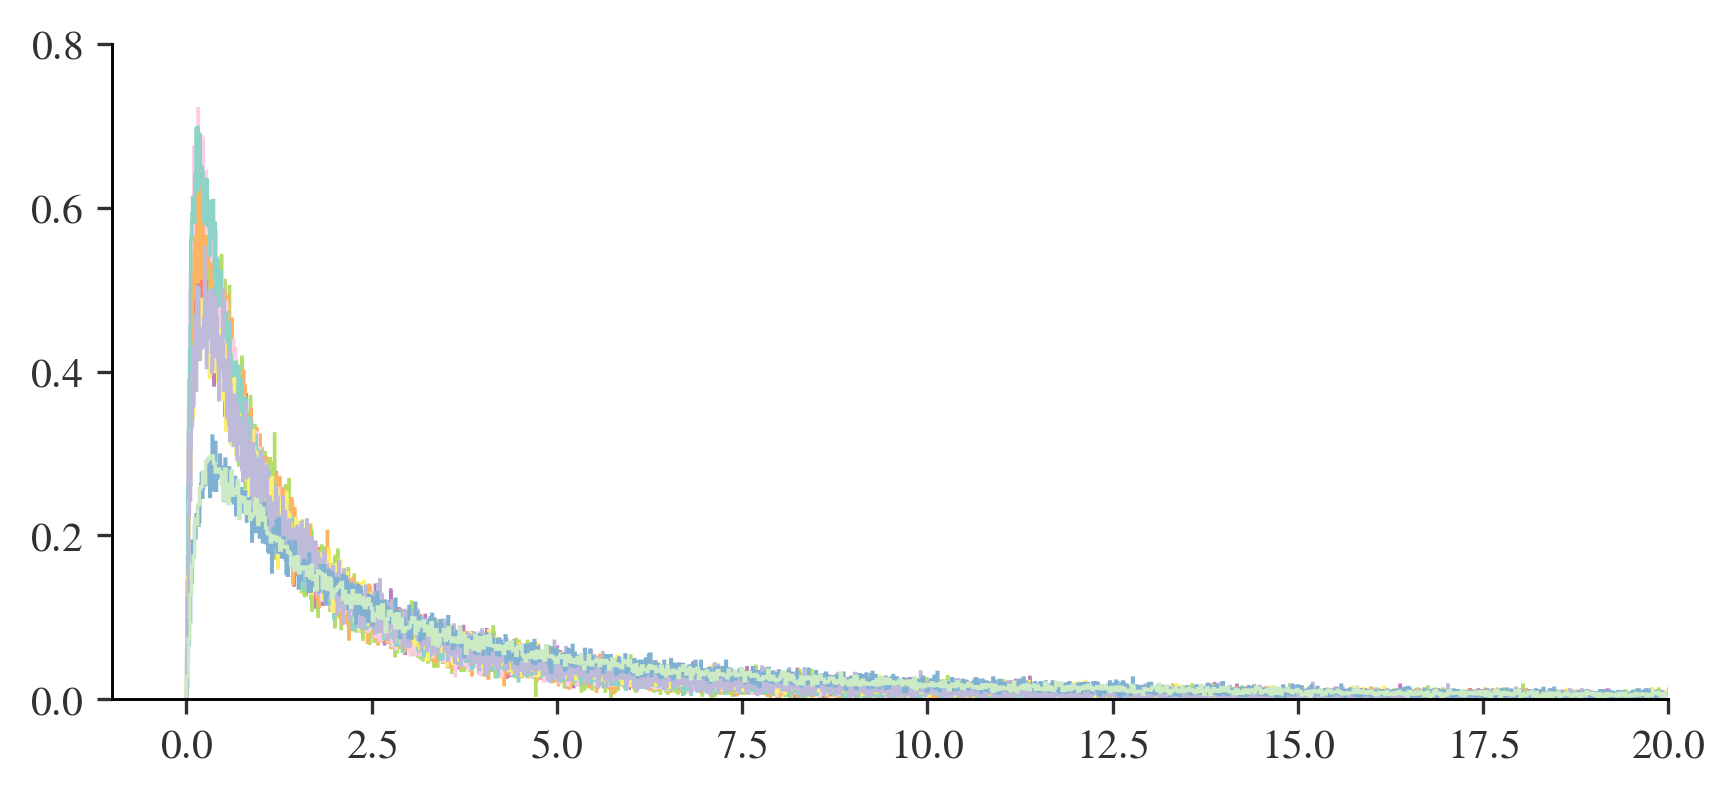

In [47]:
figsize = set_size(textwidth, subplots=(1, 1), rescale_height=0.7)

fig, ax = plt.subplots(figsize = figsize)
ax.set_xlim(left=-1, right=20)
#ax.set_xscale('log')
x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    # Load values from predictions
    mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
    sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
    Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']    

    # Load values from test dataset
    mu2 = dvar_test.iloc[datapoint]['R_median']
    sigma2 = dvar_test.iloc[datapoint]['GSD']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    # Sample from lognormal distribution between R_median and GSD
    s1 = np.random.lognormal(mu1, sigma1, 100000)
    s2 = np.random.lognormal(mu2, sigma2, 100000)

    # Create histogramm from samples 
    # [Count and bins are the same, regardless of the given histtype being 'bar' or 'step'.]
    # Only ignored changes. 'step' is much faster than 'bar', hence preferable.
    count1, bins1, ignored1 = plt.hist(s1, 100000, stacked=True, density=True, align='mid', histtype='step')
    count2, bins2, ignored2 = plt.hist(s2, 100000, stacked=True, density=True, align='mid', histtype='step')    
    
    # Create x axis
    x1 = np.linspace(min(bins1), max(bins1), 1000000)
    x2 = np.linspace(min(bins2), max(bins2), 1000000)

    # create y axis
    pdf1 = lognormal_distr(x1, mu1, sigma1, Vtot1)
    pdf2 = lognormal_distr(x2, mu2, sigma2, Vtot2)
    
    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


In [48]:
# sample, to decreaase the size of the vector grpahic
# Take first N samples anyways
N = 1000
first_samples = np.arange(N)

# Sample from len-N according to 1/(alpha*n)
alpha = 0.008

nmbr_samples = x1data[0].shape[0] - N
sample = np.random.rand(nmbr_samples)
coordinates = [int(index + N) for index, element in enumerate(sample) if element <= 1/(alpha*(index+1))]

# Combine both
sample_coord = np.hstack([first_samples, coordinates])
print(("{:35s} {:6d}".format("Number of plotted points per curve:", len(sample_coord + N))))
print(("{:35s} {:6d}".format("Total number of points:", len(sample_coord + N)*number_of_illustrative_curves)))

Number of plotted points per curve:   2276
Total number of points:              11380


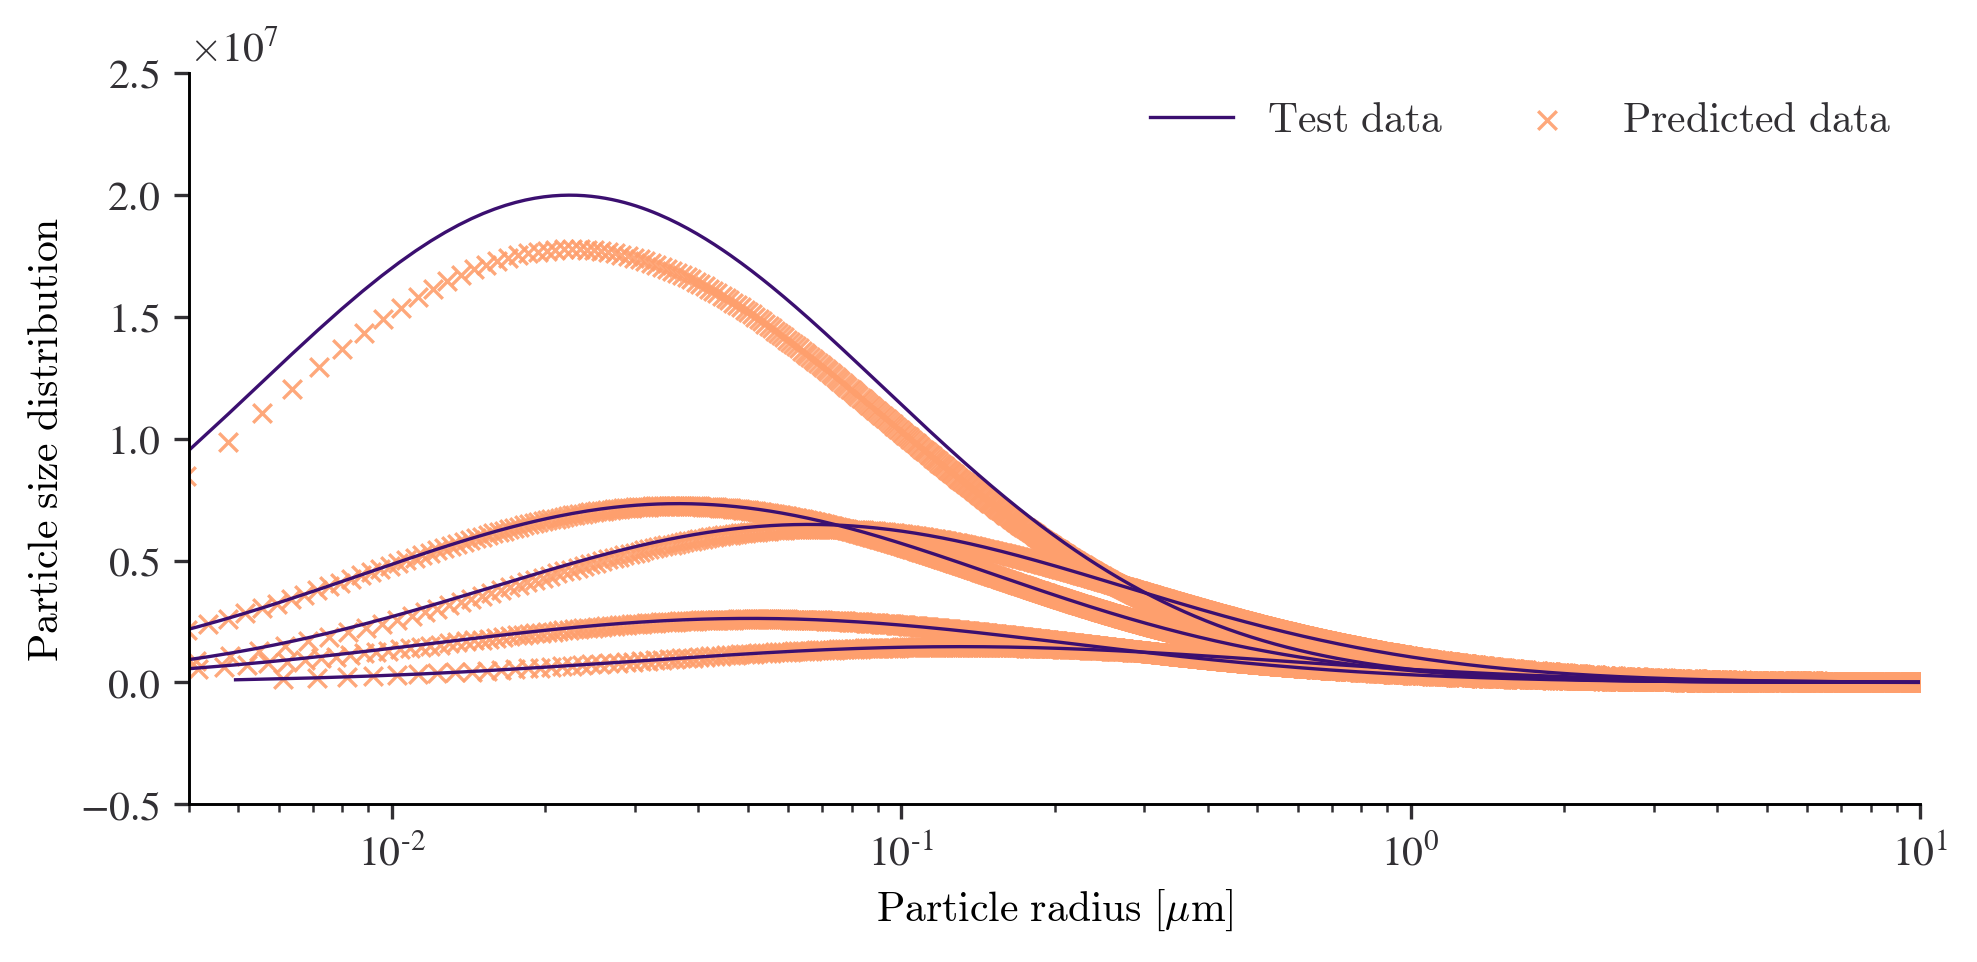

In [49]:
color = [cmap(0.8), cmap(0.2)]
scat_style = {'s': 20, 'marker': 'x', 'alpha': 0.9}

figsize = set_size(textwidth, subplots=(1, 1), rescale_height=0.8)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set_xlabel('$\operatorname{Particle\ radius}\ [\mu \operatorname{m}]$')
ax.set_ylabel('$\operatorname{Particle\ size\ distribution}$')
ax.tick_params()
ax.set_xscale('log')
ax.set_xlim(left=4*10**-3, right=10**1)
# Minor ticks
ax.tick_params(axis='x', which='minor', length=2)
ax.tick_params(axis='y', which='minor', length=2)   
    
# P11
j = 0
for datapoint in range(number_of_illustrative_curves):
    ax.scatter(x1data[datapoint][sample_coord], (y1data[datapoint]*1000)[sample_coord], color=color[0], **scat_style, label="$\operatorname{Predicted\ data}$")
    ax.plot(x2data[datapoint], y2data[datapoint]*1000, color=color[1], label="$\operatorname{Test\ data}$")
    #ax.scatter(angles, qoi_test[wl_item].iloc[index], color=color[0], **scat_style)  #, 'b*'
    #ax.scatter(angles, qoi_pred_fw[wl_item].iloc[index], color=color[1], **scat_style)  # ,'r.'
    if datapoint==0:
        ax.legend(ncol=2, frameon=False)

#fig.suptitle('$\operatorname{Qualitative\ comparison\ of\ test\ data\ with\ predicted\ data}$')
fig.tight_layout()
if save_to_file:
    fig.savefig(f'{plot_dir}/GSD_GMR_iv' + '.pdf', dpi=500) #, dpi=400, rasterized=True)
plt.show()

In [50]:
# # Choose indeces of curves to draw for illustrative purposes
# number_of_illustrative_curves = 5
# presentation_plot_index = [i*(qoi_test.shape[0]//number_of_illustrative_curves) for i in range(number_of_illustrative_curves)]
# presentation_plot_index = [13000, 8000, 15000, 1000, 4000] # 0, 1000, 2000, 5000 8000 vs [0, 4000, 8000, 12000, 16000]

# figsize = set_size(textwidth, subplots=(1, 1), rescale_height=0.7)

# fig, ax = plt.subplots(figsize = figsize)
# ax.set_xlim(left=-1, right=20)
# #ax.set_xscale('log')
# x1data = []
# x2data = []
# y1data = []
# y2data = []

# for datapoint in presentation_plot_index:
#     # Load values from predictions
#     mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
#     sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
#     Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']    

#     # Load values from test dataset
#     mu2 = dvar_test.iloc[datapoint]['R_median']
#     sigma2 = dvar_test.iloc[datapoint]['GSD']
#     Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
#     # Sample from lognormal distribution between R_median and GSD
#     s1 = np.random.lognormal(mu1, sigma1, 100000)
#     s2 = np.random.lognormal(mu2, sigma2, 100000)

#     # Create histogramm from samples 
#     # [Count and bins are the same, regardless of the given histtype being 'bar' or 'step'.]
#     # Only ignored changes. 'step' is much faster than 'bar', hence preferable.
#     count1, bins1, ignored1 = plt.hist(s1, 100000, stacked=True, density=True, align='mid', histtype='step')
#     count2, bins2, ignored2 = plt.hist(s2, 100000, stacked=True, density=True, align='mid', histtype='step')    
    
#     # Create x axis
#     x1 = np.linspace(min(bins1), max(bins1), 1000000)
#     x2 = np.linspace(min(bins2), max(bins2), 1000000)

#     # create y axis
#     pdf1 = lognormal_distr(x1, mu1, sigma1, Vtot1)
#     pdf2 = lognormal_distr(x2, mu2, sigma2, Vtot2)
    
#     x1data.append(x1)
#     x2data.append(x2)
#     y1data.append(pdf1)
#     y2data.append(pdf2)

# # sample, to decreaase the size of the vector grpahic
# # Take first N samples anyways
# N = 1000
# first_samples = np.arange(N)

# # Sample from len-N according to 1/(alpha*n)
# alpha = 0.008

# nmbr_samples = x1data[0].shape[0] - N
# sample = np.random.rand(nmbr_samples)
# coordinates = [int(index + N) for index, element in enumerate(sample) if element <= 1/(alpha*(index+1))]

# # Combine both
# sample_coord = np.hstack([first_samples, coordinates])
# print(("{:35s} {:6d}".format("Number of plotted points per curve:", len(sample_coord + N))))
# print(("{:35s} {:6d}".format("Total number of points:", len(sample_coord + N)*number_of_illustrative_curves)))

# color = [cmap(0.8), cmap(0.2)]
# scat_style = {'s': 20, 'marker': 'x', 'alpha': 0.9}

# figsize = set_size(textwidth, subplots=(1, 1), rescale_height=0.8)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
# ax.set_xlabel('$\operatorname{Particle\ radius}\ [\mu \operatorname{m}]$')
# ax.set_ylabel('$\operatorname{Concentration}$')
# ax.tick_params()
# ax.set_xscale('log')
# ax.set_xlim(left=4*10**-3, right=10**1)
# # Minor ticks
# ax.tick_params(axis='x', which='minor', length=2)
# ax.tick_params(axis='y', which='minor', length=2)   
    
# # P11
# j = 0
# for datapoint in range(number_of_illustrative_curves):
#     ax.scatter(x1data[datapoint][sample_coord], (y1data[datapoint]*1000)[sample_coord], label=datapoint, **scat_style)
#     ax.plot(x2data[datapoint], y2data[datapoint]*1000, color=color[1])
#     #ax.scatter(angles, qoi_test[wl_item].iloc[index], color=color[0], **scat_style)  #, 'b*'
#     #ax.scatter(angles, qoi_pred_fw[wl_item].iloc[index], color=color[1], **scat_style)  # ,'r.'
# plt.legend()
# fig.suptitle('$\operatorname{Qualitative\ comparison\ of\ test\ data\ with\ predicted\ data}$')
# fig.tight_layout()
# plt.show()

In [51]:
surr.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 328)]             0         
_________________________________________________________________
affine_coupling_block (Affin (None, 328)               176396    
_________________________________________________________________
permutation_layer (Permutati (None, 328)               0         
_________________________________________________________________
affine_coupling_block_1 (Aff (None, 328)               176396    
_________________________________________________________________
permutation_layer_1 (Permuta (None, 328)               0         
_________________________________________________________________
affine_coupling_block_2 (Aff (None, 328)               176396    
_________________________________________________________________
permutation_layer_2 (Permuta (None, 328)               0     

# Unused / Graveyard of plots

## Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [52]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
    MAPE_all_dvar.append(MAPE)
    #print(col,'MAE: ***',MAE,'MAPE in % ***', MAPE)
    #print("{:9s} {:>8.5f} {:>8.5f}".format(col, MAE, MAPE))

In [53]:
MAE_all_dvar = pd.DataFrame([np.array(MAE_all_dvar)], index = ['MAE_dvar'],columns = dvar_columns)
MAPE_all_dvar = pd.DataFrame([np.array(MAPE_all_dvar)], index = ['MAPE_dvar'], columns = dvar_columns)

In [54]:
pd.concat([MAE_all_dvar, MAPE_all_dvar], axis=0)

$n_{532}$  $k_{532}$  $V_{tot}$     $r_m$  $\sigma$
MAE_dvar    0.001238   0.000796  26.098438  0.006826  0.002131
MAPE_dvar   0.084592   5.156590   7.207275  0.905614  0.149583

In [55]:
MAE_all_qoi = []
MAPE_all_qoi = []
print("{:15s} {:>8.5s} {:>8.5s} %".format('Column name', 'MAE', 'MAPE'))
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    #print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
    #print("{:15s} {:>8.5f} {:>8.5f}".format(col, MAE, MAPE))
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

Column name          MAE     MAPE %


In [56]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
print("{:8s}{:4s}{:>9.5f}".format('Maximum', 'MAE', MAE_all_qoi.max(axis = 1)[0]))
print("{:8s}{:4s}{:>9.5f}".format('Mean', 'MAE', MAE_all_qoi.mean(axis = 1)[0]))
print("{:8s}{:4s}{:>9.5f}".format('Maximum', 'MAPE', MAPE_all_qoi.max(axis = 1)[0]))
print("{:8s}{:4s}{:>9.5f}".format('Mean', 'MAPE', MAPE_all_qoi.mean(axis = 1)[0]))

Maximum MAE   0.04296
Mean    MAE   0.01406
Maximum MAPE  3.42784
Mean    MAPE  0.12983


In [57]:
pd.concat([MAPE_all_qoi, MAE_all_qoi], axis=0)

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
MAPE_qoi     0.001458     0.001272     0.001261     0.001402     0.001246   
MAE_qoi      0.024009     0.021450     0.021606     0.024107     0.021948   

          P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
MAPE_qoi      0.001181      0.001245      0.001342      0.001369   
MAE_qoi       0.021173      0.022443      0.024279      0.024886   

          P11_0.532_14  ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  \
MAPE_qoi      0.001358  ...       1.814386       0.279059       0.274088   
MAE_qoi       0.024913  ...       0.004263       0.003951       0.003634   

          P12_0.532_169  P12_0.532_170  P12_0.532_171  P12_0.532_172  \
MAPE_qoi       0.256235       0.980624       0.495788       0.282317   
MAE_qoi        0.003499       0.003647       0.003048       0.002877   

          P12_0.532_173  P12_0.532_174  P12_0.532_175  
MAPE_qoi       0.279280       3.427839       2.176581  
MAE_qoi        0.002644       0.002349       0.001926  

[2 rows x 320 columns]

In [58]:
MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

P12_0.532_174  P12_0.532_175  P12_0.532_166  P12_0.532_154  \
MAPE_qoi       3.427839       2.176581       1.814386       1.567679   

          P12_0.532_54  P12_0.532_162  P12_0.532_170  P12_0.532_50  \
MAPE_qoi      1.366599       1.130543       0.980624      0.955475   

          P12_0.532_155  P12_0.532_156  ...  P11_0.532_84  P11_0.532_117  \
MAPE_qoi       0.915308       0.638919  ...      0.000926        0.00092   

          P11_0.532_127  P11_0.532_111  P11_0.532_110  P11_0.532_130  \
MAPE_qoi       0.000919       0.000914       0.000914       0.000892   

          P11_0.532_96  P11_0.532_112  P11_0.532_104  P11_0.532_125  
MAPE_qoi      0.000879       0.000871        0.00086       0.000832  

[1 rows x 320 columns]

## Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [59]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    # print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_columns).T

In [60]:
RMSE_dvar

$n_{532}$  $k_{532}$  $V_{tot}$     $r_m$  $\sigma$
0    0.00206   0.001826   38.63819  0.009718  0.003164

In [61]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    # print(col,'RMSE: ',RMSE)
RMSE_qoi =  pd.DataFrame([np.array(RMSE_qoi)])

In [62]:
(RMSE_qoi.T).describe().T

count      mean      std       min       25%       50%       75%       max
0  320.0  0.025834  0.02153  0.000053  0.004767  0.025841  0.046774  0.066193

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [63]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_columns).T
EVS_dvar

$n_{532}$  $k_{532}$  $V_{tot}$     $r_m$  $\sigma$
0   0.999323   0.998128   0.999308  0.999797  0.951396

In [64]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    # print(col,'***',EVS)
    EVS_all.append(EVS)
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0     0.997958     0.998166     0.998419     0.998709     0.998907   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0      0.999017      0.999102      0.999063      0.999142      0.999175  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0       0.999028       0.999047        0.99905       0.998947       0.998645   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0       0.998776       0.998594       0.998215       0.998012       0.998126  

[1 rows x 320 columns]

In [65]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)

P11_0.532_5  P12_0.532_174  P12_0.532_175  P11_0.532_6  P12_0.532_173  \
0     0.997958       0.998012       0.998126     0.998166       0.998215   

   P11_0.532_99  P11_0.532_7  P11_0.532_109  P12_0.532_172  P12_0.532_170  \
0      0.998336     0.998419       0.998536       0.998594       0.998645   

   ...  P12_0.532_61  P12_0.532_34  P12_0.532_81  P12_0.532_53  P12_0.532_55  \
0  ...      0.999734      0.999735       0.99974      0.999743      0.999745   

   P12_0.532_47  P12_0.532_39  P12_0.532_58  P12_0.532_69  P12_0.532_45  
0      0.999751      0.999754      0.999755      0.999755      0.999759  

[1 rows x 320 columns]

In [66]:
# EVS_all_df.apply(pd.DataFrame.describe,axis = 1)